In [1]:
import os, joblib, torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy.stats import wasserstein_distance

from model import *
from utils import *
from data_loader import *
from test_metrics import *
from preprocess.gaussianize import *


# COSCI-GAN 디렉토리로 이동
path = '/workspace/COSCI-GAN_Journal'
try:
    os.chdir(path)
    print("Current working directory: {0}".format(os.getcwd()))
except FileNotFoundError:
    print("Directory {0} does not exist".format(path))

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
set_seed(0)

sns.set(style="darkgrid")

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Current working directory: /workspace/COSCI-GAN_Journal_new


In [2]:
full_name = 'LSTM_LSTM_MLP_500_128_gamma_5.0_Glr_0.0005_Dlr_0.0005_CDlr_0.0001_seqlen_36_loss_BCE_NEW'
n_groups = 5          # 학습한 자산 수
noise = torch.randn(100, 3, 127)

In [3]:
### Find the best epochs based on 100 days distribution
window = 100
generator = {}
best_epochs = [0] * n_groups
min_emd = [0] * n_groups

for asset_idx in range(0, n_groups):    
    min_distance = float('inf')  
    
    for asset_epoch in range(190, 255, 5):        
        generator_tmp = LSTMGenerator(3, 1)
        generator_temp_dict = torch.load(f'./Results/{full_name}/Generator_{asset_idx}_{asset_epoch}.pt')            
        new_generator_temp_dict = deepcopy(generator_temp_dict)             
        for key in generator_temp_dict.keys():
            new_generator_temp_dict[key[7:]] = new_generator_temp_dict.pop(key)
        generator_tmp.load_state_dict(new_generator_temp_dict)                          
        
        y = generator_tmp(noise).cpu().detach().squeeze()               
        y, log_returns = inverse_process(y, asset_idx)
        if y.size == 0:            
            continue
                
        real_dist = rolling_window(log_returns, window).sum(axis=0).ravel()
        fake_dist = rolling_window(y.T, window).sum(axis=0).ravel()
        
        emd = wasserstein_distance(real_dist, fake_dist)        
        if emd < min_distance:
            min_distance = emd
            best_epochs[asset_idx] = asset_epoch        
            min_emd[asset_idx] = min_distance    
            generator[asset_idx] = generator_tmp
            print(f"min_distance:{min_distance}, best_epochs:{asset_epoch}")
    print()

print()
print(f"best_epochs = {best_epochs}")
print(f"min_emd = {min_emd}")

min_distance:0.11411331918395134, best_epochs:190
min_distance:0.09849034771137771, best_epochs:195
min_distance:0.03343122957352894, best_epochs:210
min_distance:0.013659871904182606, best_epochs:250

min_distance:0.11404044067411732, best_epochs:190
min_distance:0.031831402420814434, best_epochs:195
min_distance:0.031165538340508857, best_epochs:210
min_distance:0.01827167719817075, best_epochs:225
min_distance:0.01783448186988684, best_epochs:240
min_distance:0.012102932470203102, best_epochs:250

min_distance:0.094535949855686, best_epochs:190
min_distance:0.07376411372247071, best_epochs:195
min_distance:0.037438546682745835, best_epochs:200
min_distance:0.03657961134668805, best_epochs:225
min_distance:0.021562719964976863, best_epochs:230
min_distance:0.019789590493454814, best_epochs:250

min_distance:0.03481884633132427, best_epochs:190
min_distance:0.010645012422943825, best_epochs:195

min_distance:0.18789224104091246, best_epochs:190
min_distance:0.13782372267624232, best_e

In [4]:
asset_num = 5000                           # 생성할 데이터의 개수
seq_len = 127                         # 생성할 데이터의 길이
noise = torch.randn(asset_num, 3, seq_len)

In [5]:
### 데이터 생성
real = []
fake_list = []
real_list = []

for i in range(0, n_groups):
    
    y = generator[i](noise).cpu().detach().squeeze()
    y, log_returns = inverse_process(y, i)        

    y = y[(y.max(axis=1) <= 2.0 * log_returns.max()) & (y.min(axis=1) >= 2.0 * log_returns.min())]
    print(y.shape)
    
    fake_list.append(y)
    real.append(log_returns)

for i in range(len(real)):        
    real_list.append(np.array(rolling_window_seqlen(real[i], seq_len)).squeeze())
    
# 합성 데이터 저장
joblib.dump(fake_list, './fake_list.pkl')


(5000, 127)
(5000, 127)
(5000, 127)
(5000, 127)
(5000, 127)


['./fake_list.pkl']

In [6]:
print(type(real))
print(len(real), real[0].shape, '\n')

print(type(real_list))
print(len(real_list), real_list[0].shape, '\n')

print(type(fake_list))
print(len(fake_list), fake_list[0].shape)

<class 'list'>
5 (5031, 1) 

<class 'list'>
5 (4904, 127) 

<class 'list'>
5 (5000, 127)


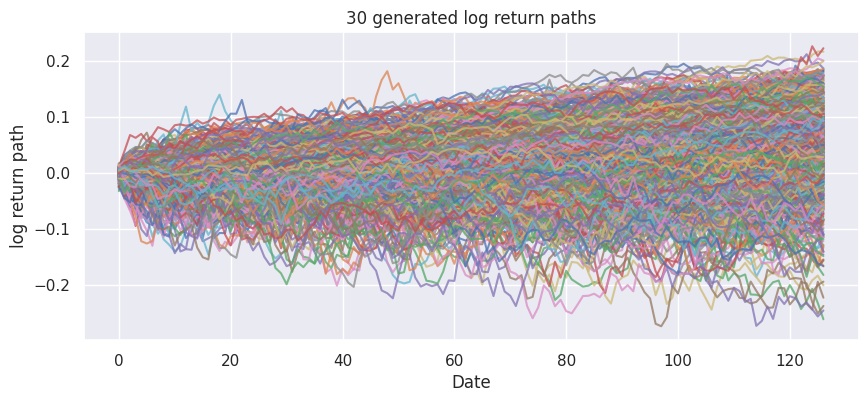

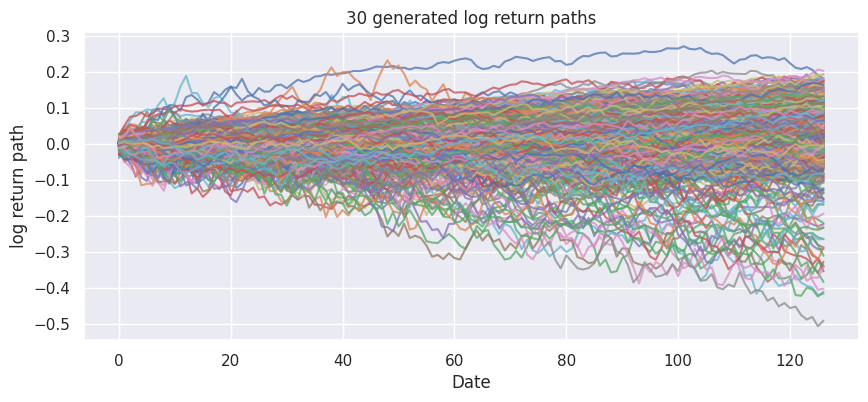

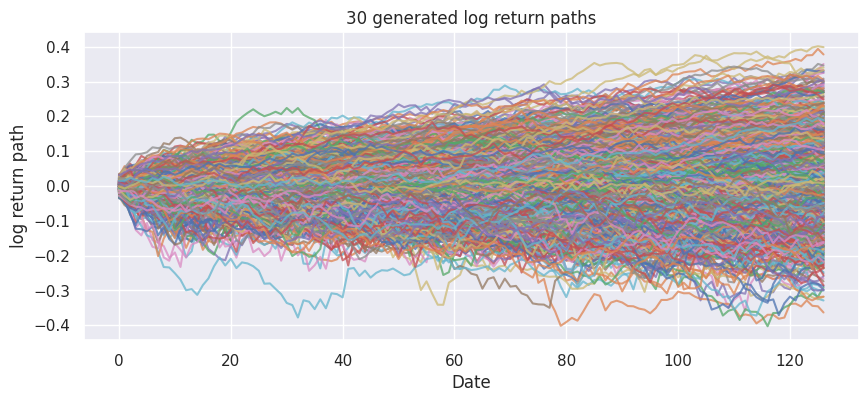

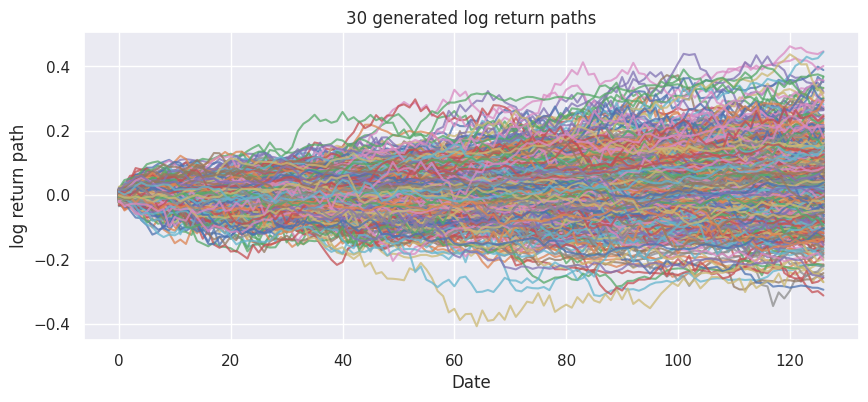

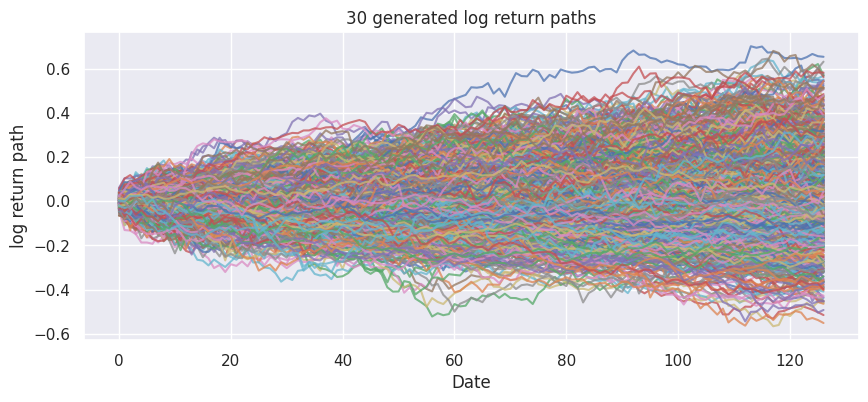

In [7]:
# # plot the 30 generated log return paths
for i in range(5):
    fig, ax = plt.subplots(figsize=(10,4))
    ax.plot(np.cumsum(fake_list[i][0:1000], axis=1).T, alpha=0.75)
    ax.set_title('30 generated log return paths')
    ax.set_xlabel('Date')

    ax.set_ylabel('log return path')

In [8]:
windows = pd.Series([1, 5, 20, 100], name='window size')

# Calculate EMD scores
results_emd = calculate_distribution_scores(real, fake_list, n_groups, windows)
results_emd

{'EMD':               EMD 0   EMD 1   EMD 2   EMD 3   EMD 4
 window size                                        
 1            0.0011  0.0011  0.0015  0.0007  0.0019
 5            0.0018  0.0015  0.0039  0.0020  0.0076
 20           0.0063  0.0064  0.0091  0.0051  0.0232
 100          0.0167  0.0151  0.0214  0.0076  0.0577,
 'KL':                KL 0    KL 1    KL 2    KL 3    KL 4
 window size                                        
 1            0.0723  0.0716  0.0524  0.0250  0.0634
 5            0.0438  0.0400  0.0394  0.0334  0.1385
 20           0.1037  0.0750  0.0668  0.0460  0.2293
 100          0.3286  0.1281  0.2904  0.0300  0.4501,
 'JS':                JS 0    JS 1    JS 2    JS 3    JS 4
 window size                                        
 1            0.0859  0.0886  0.0889  0.0587  0.0650
 5            0.0652  0.0578  0.0794  0.0866  0.1024
 20           0.1009  0.0941  0.1021  0.1047  0.1364
 100          0.1285  0.1297  0.1248  0.0850  0.1596,
 'KS':                KS

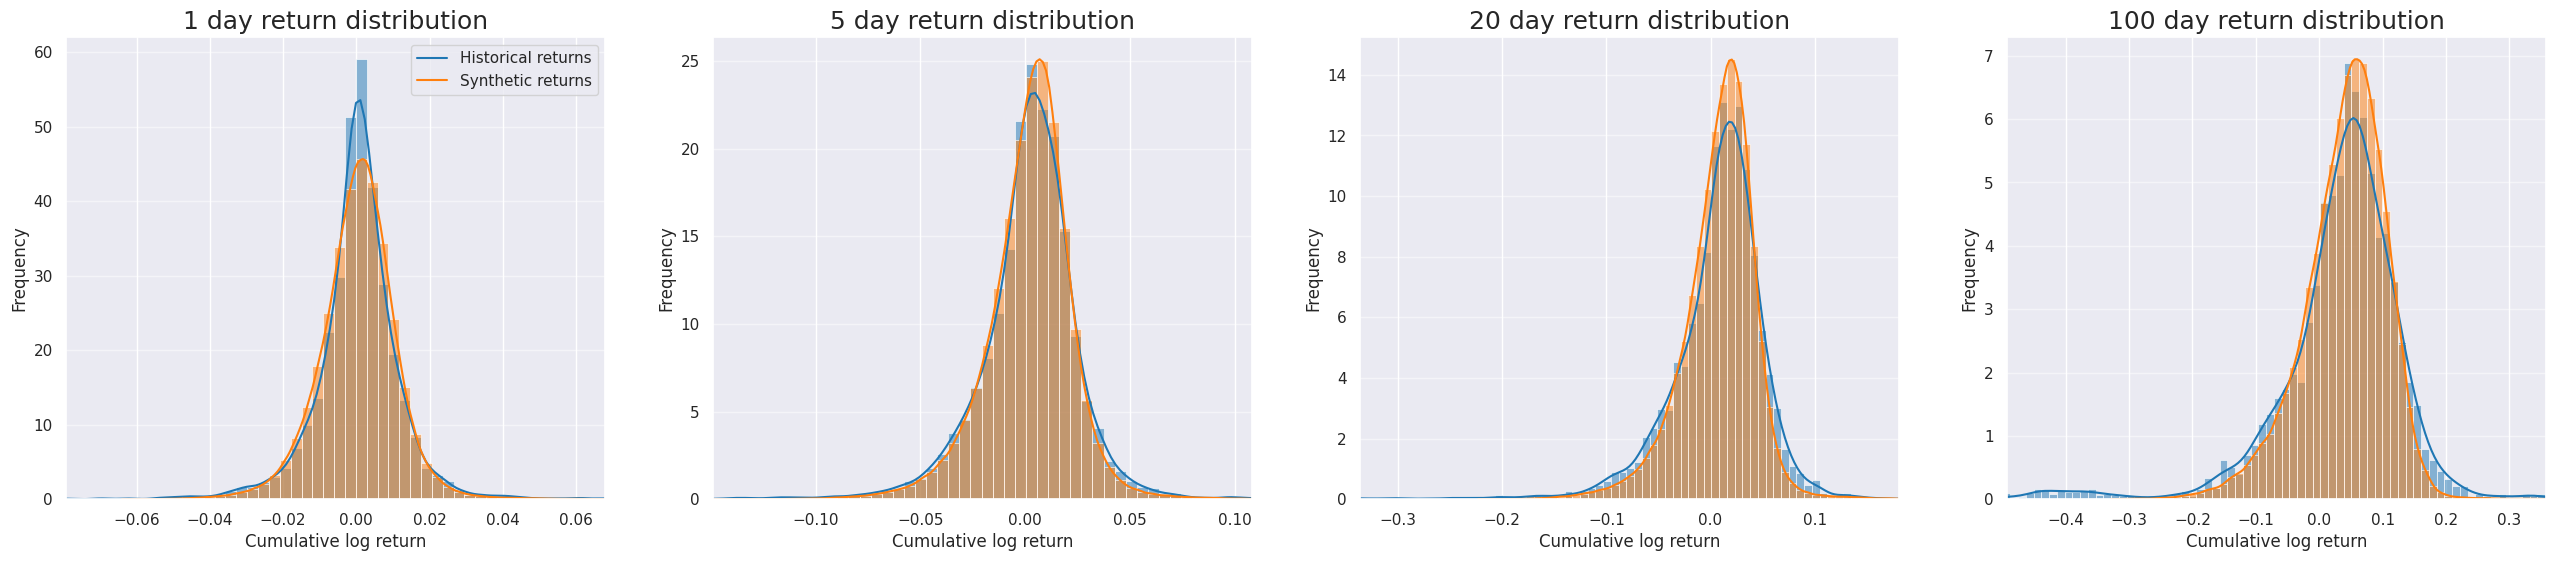

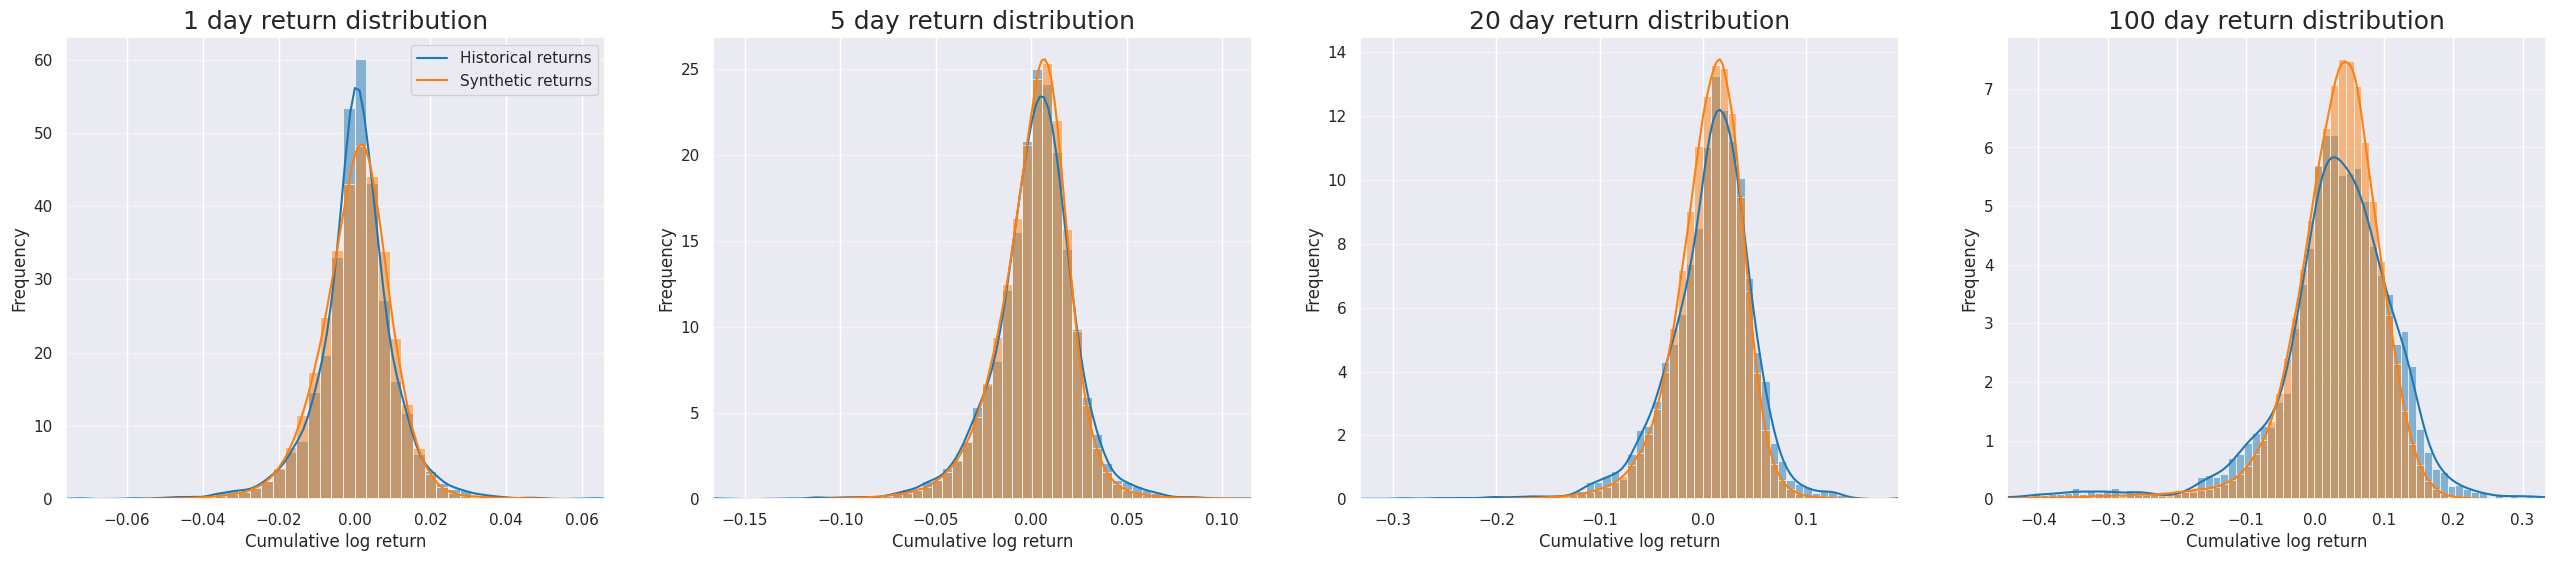

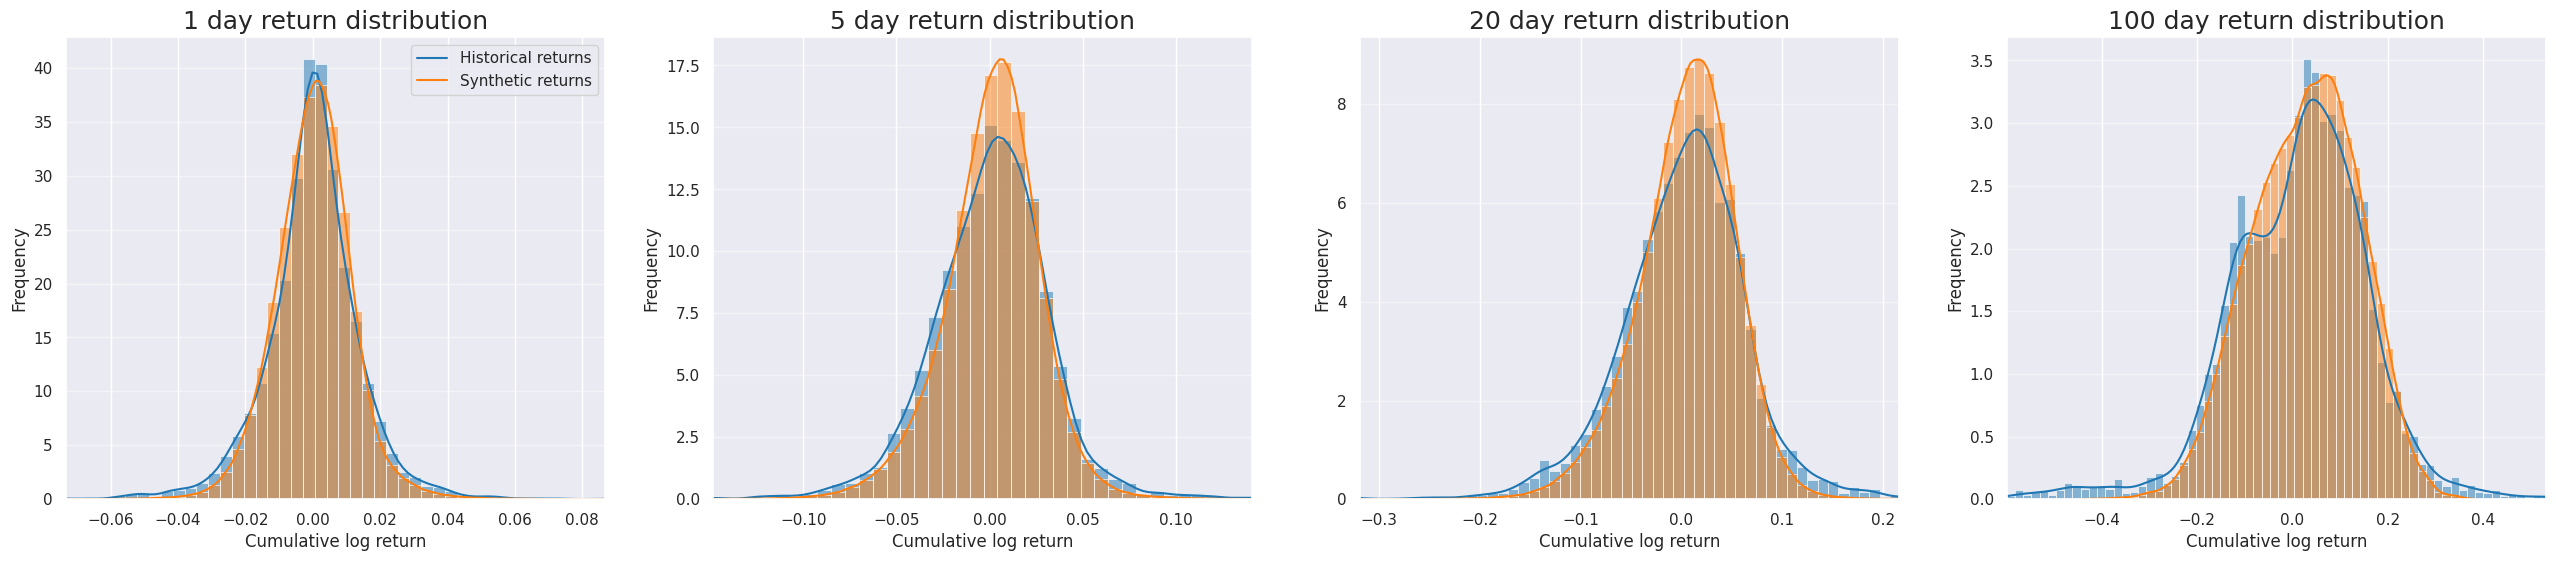

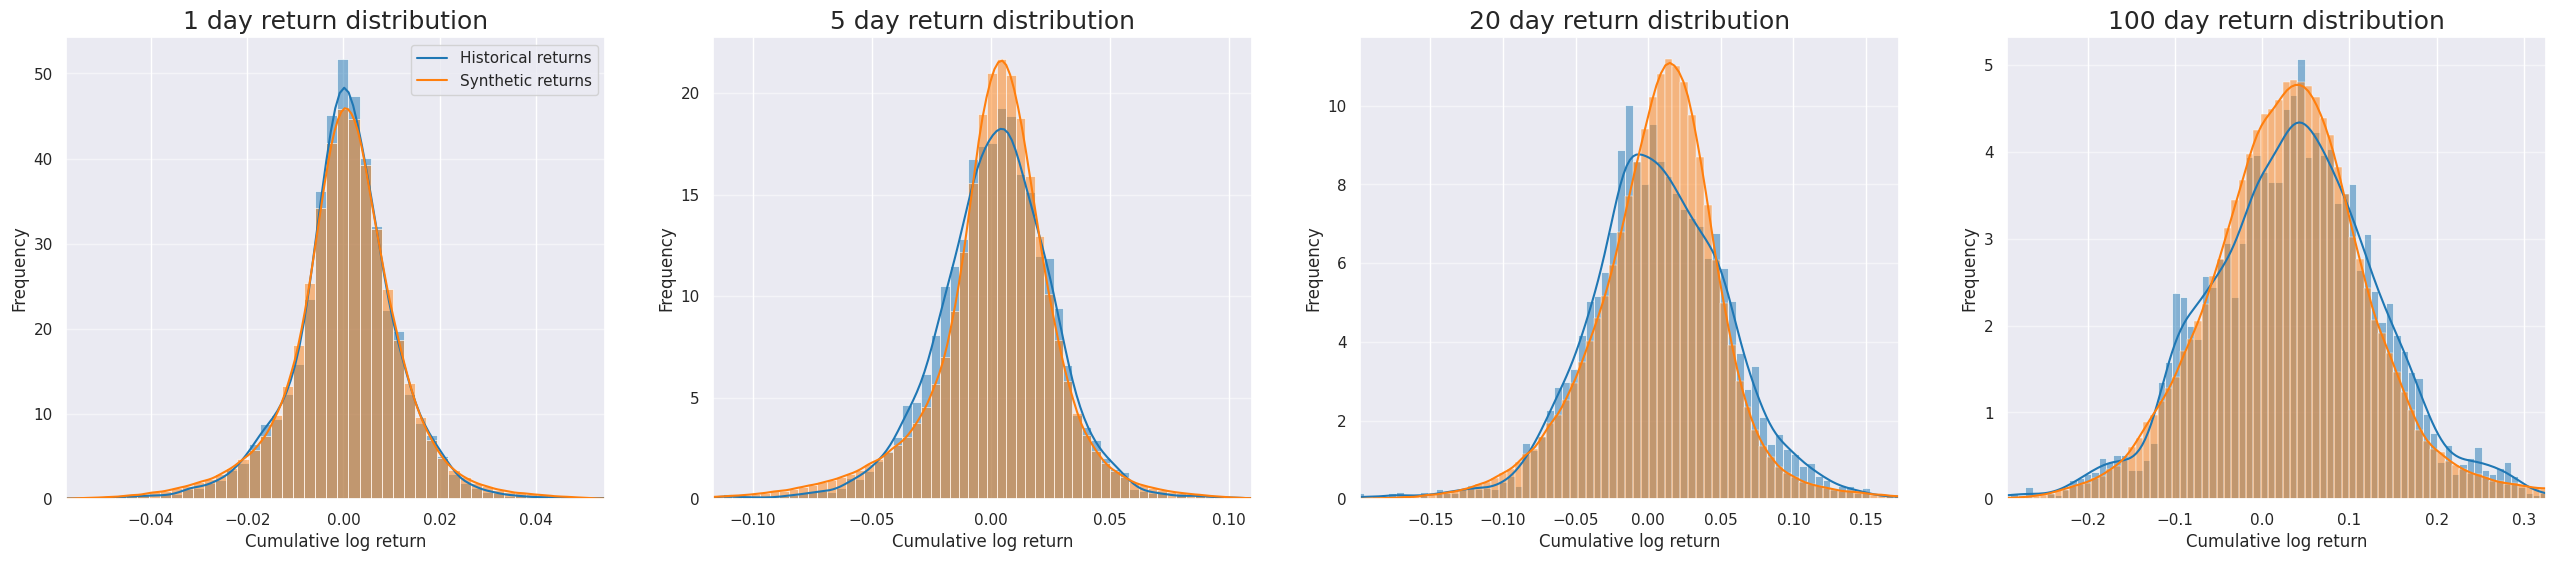

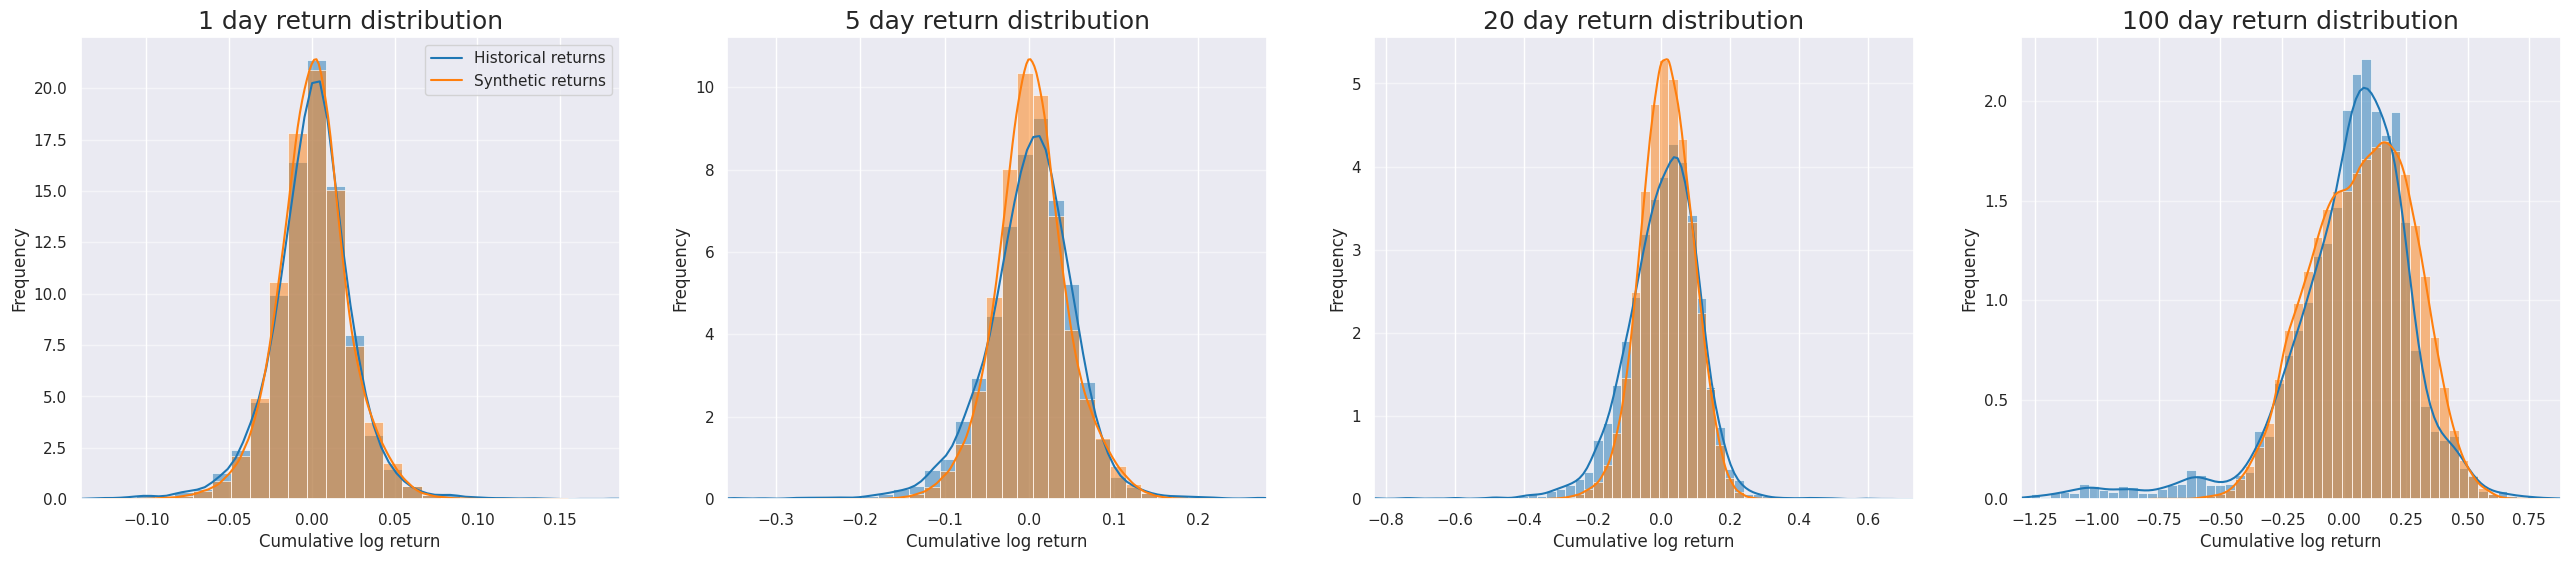

In [9]:
windows = [1, 5, 20, 100]
for j in range(n_groups):
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(32, 6))  

    for i in range(len(windows)):
        col = i

        real_dist = rolling_window(real[j], windows[i]).sum(axis=0).ravel()
        fake_dist = rolling_window(fake_list[j].T, windows[i]).sum(axis=0).ravel()
        
        # 두 데이터의 최소값과 최대값을 계산
        #min_val = min(real_dist.min(), fake_dist.min())
        #max_val = max(real_dist.max(), fake_dist.max())
        min_val = real_dist.min()
        max_val = real_dist.max()

        # 동일한 bin 경계 계산 (간격 동일하게)
        bins = np.linspace(min_val, max_val, 81)  # 80개의 bin 경계 생성
        
        sns.histplot(real_dist, bins=bins, kde=True, ax=axs[col], color='tab:blue', alpha=0.5, stat='density')
        sns.histplot(fake_dist, bins=bins, kde=True, ax=axs[col], color='tab:orange', alpha=0.5, stat='density')

        axs[col].set_xlim(*np.quantile(real_dist, [0.001, .999]))
        
        axs[col].set_title('{} day return distribution'.format(windows[i]), size=18)
        axs[col].yaxis.grid(True, alpha=0.5)
        axs[col].set_xlabel('Cumulative log return', fontsize=12)
        axs[col].set_ylabel('Frequency', fontsize=12)

    axs[0].legend(['Historical returns', 'Synthetic returns'])

plt.show()

In [10]:
# Correlation Analysis of synthetic data
df_fake = []        
for i in range(n_groups):
    
    y = generator[i](noise).cpu().detach().squeeze()
    y, log_returns = inverse_process(y, i)        
    
    df = pd.DataFrame(y)    
    df_fake.append(df)
    
df_fake_merge = pd.concat(df_fake, axis=1)
corr_fake, avg_fake, _ = calculate_correlation(df_fake_merge, seq_len)

### Correlation Analysis - real data
real_merge = np.transpose(np.stack(real_list), axes=(1, 0, 2))
real_merge = real_merge.reshape(real_merge.shape[0], -1)
df_real_merge = pd.DataFrame(real_merge)
_, avg_real, _ = calculate_correlation(df_real_merge, seq_len)


Mean of synthetic data correlation
          Asset1    Asset2    Asset3    Asset4    Asset5
Asset1  1.000000  0.977557  0.166589  0.156254  0.273953
Asset2  0.977557  1.000000  0.185991  0.141248  0.272472
Asset3  0.166589  0.185991  1.000000  0.046212  0.230004
Asset4  0.156254  0.141248  0.046212  1.000000  0.169529
Asset5  0.273953  0.272472  0.230004  0.169529  1.000000

Standard Deviation of synthetic data correlation
          Asset1    Asset2    Asset3    Asset4    Asset5
Asset1  0.000000  0.022729  0.207452  0.092482  0.124630
Asset2  0.022729  0.000000  0.220894  0.093305  0.137587
Asset3  0.207452  0.220894  0.000000  0.105996  0.151856
Asset4  0.092482  0.093305  0.105996  0.000000  0.102532
Asset5  0.124630  0.137587  0.151856  0.102532  0.000000

Mean of synthetic data correlation
          Asset1    Asset2    Asset3    Asset4    Asset5
Asset1  1.000000  0.960225  0.207354  0.012744  0.232040
Asset2  0.960225  1.000000  0.198390 -0.008253  0.221726
Asset3  0.207354  0.198

In [11]:
mae = calculate_mae(avg_real, avg_fake)
mae_mean, mae_std = calculate_mae_mean(avg_real, corr_fake)

frobenius = calculate_frobenius(avg_real, avg_fake)
spearman = calculate_spearman(avg_real, avg_fake)
kendall = calculate_kendall(avg_real, avg_fake)


print("MAE mean:", mae)
print("Frobenius", frobenius)
print("Spearman", spearman)
print("Kendall:", kendall)
print("MAE mean:", mae_mean, "MAE std:", mae_std)

MAE mean: 0.047066660750802694
Frobenius 0.33998339375084163
Spearman 0.9190661478599221
Kendall: 0.7714285714285714
MAE mean: 0.10040588465397507 MAE std: 0.028794140767231798


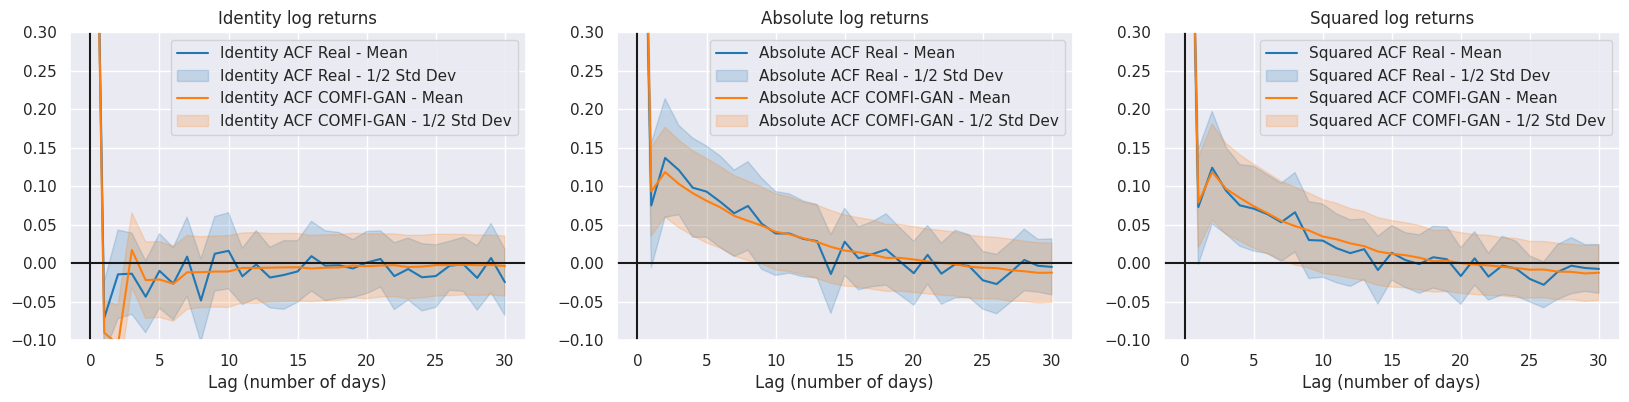

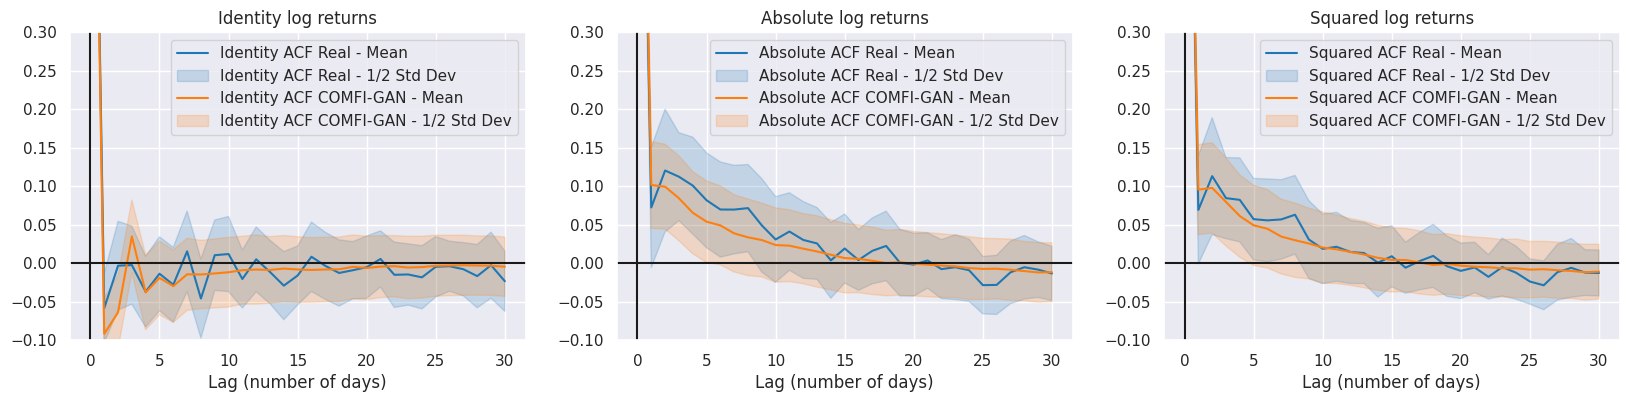

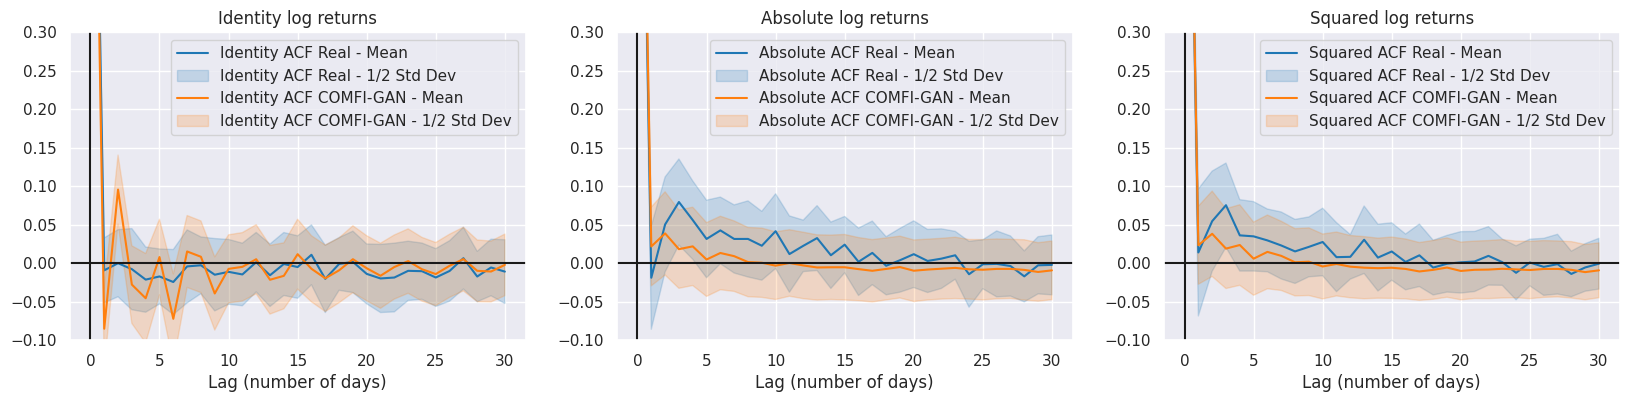

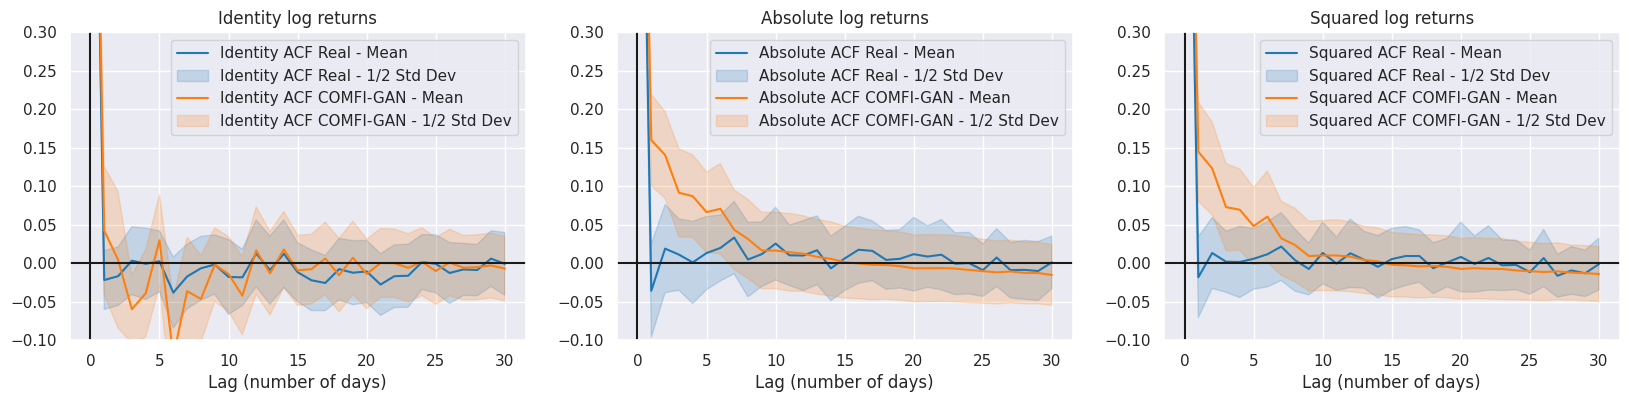

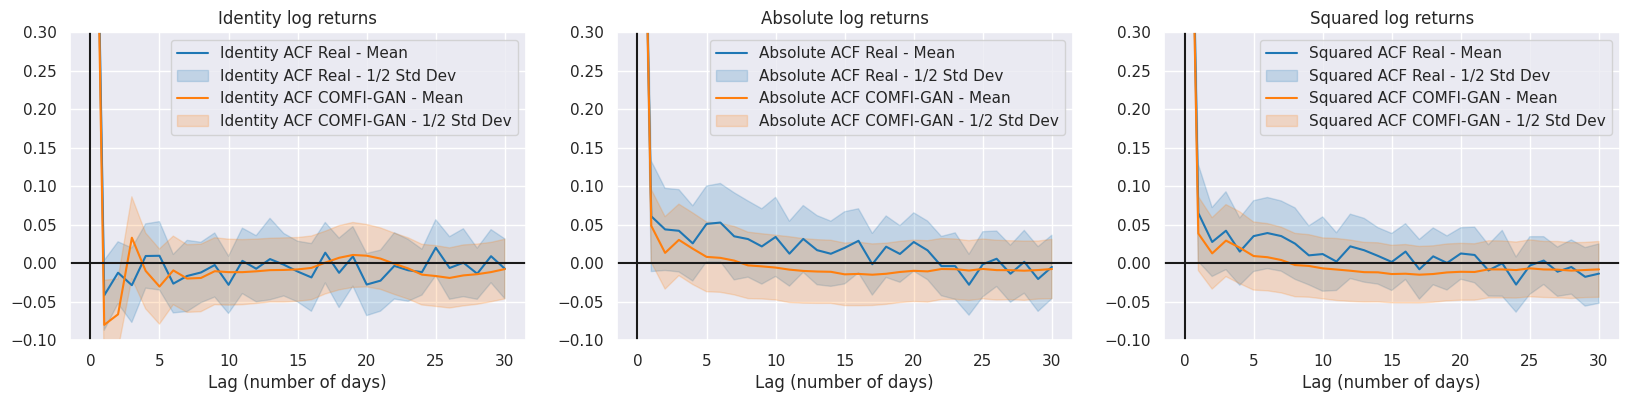

In [12]:
# ACF 비교 플롯
plot_acf_comparison(real_list, fake_list, n_groups, lags=30)

In [13]:
acf_score = calculate_acf_score(real_list, fake_list)

# Display the scores for each group
for group, scores in acf_score.items():
    print(f"{group}:")
    for title, score in scores.items():
        print(f"  {title}: {score}")


Group 1:
  Identity log returns: 0.1244
  Absolute log returns: 0.0698
  Squared log returns: 0.0544
Group 2:
  Identity log returns: 0.1071
  Absolute log returns: 0.0988
  Squared log returns: 0.0668
Group 3:
  Identity log returns: 0.1471
  Absolute log returns: 0.1327
  Squared log returns: 0.101
Group 4:
  Identity log returns: 0.1533
  Absolute log returns: 0.2756
  Squared log returns: 0.2343
Group 5:
  Identity log returns: 0.1285
  Absolute log returns: 0.1455
  Squared log returns: 0.1048
